## **Llama 3 + GroQ + CrewAI**

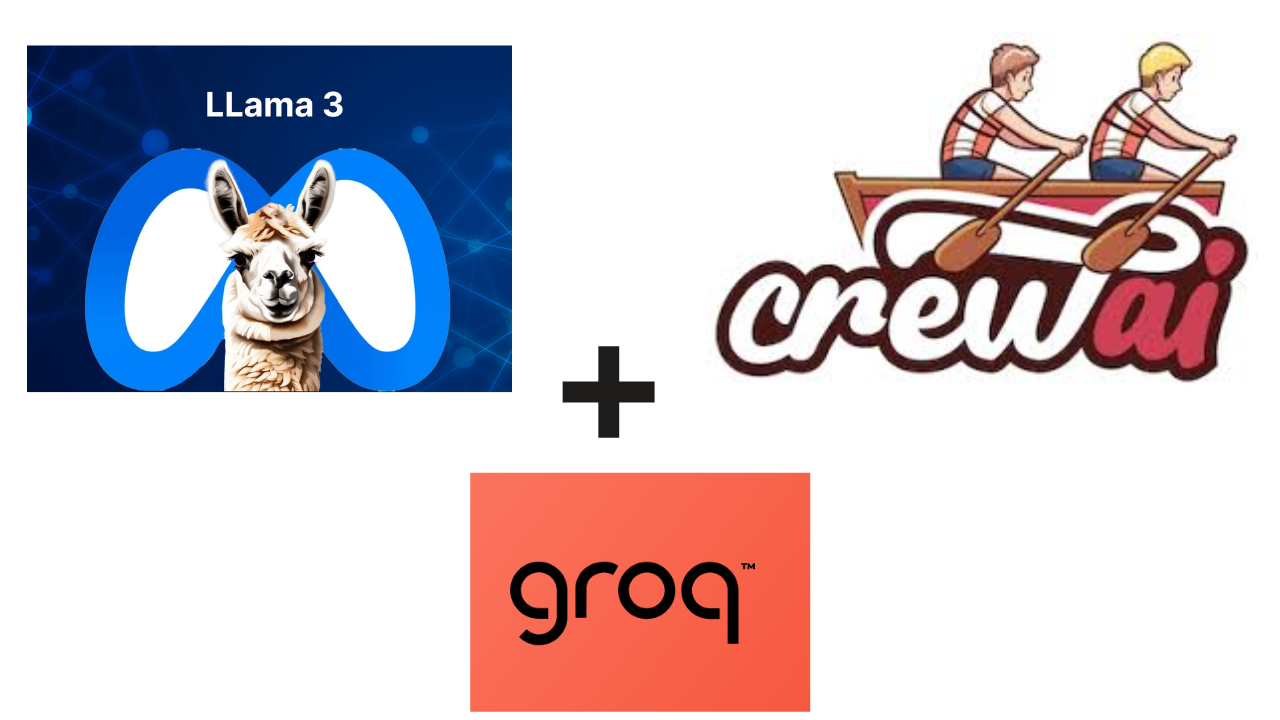

In [1]:
!pip -q install crewai langchain-groq duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
!pip show crewai

Name: crewai
Version: 0.28.8
Summary: Cutting-edge framework for orchestrating role-playing, autonomous AI agents. By fostering collaborative intelligence, CrewAI empowers agents to work together seamlessly, tackling complex tasks.
Home-page: 
Author: Joao Moura
Author-email: joao@crewai.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: appdirs, click, embedchain, instructor, langchain, openai, opentelemetry-api, opentelemetry-exporter-otlp-proto-http, opentelemetry-sdk, pydantic, python-dotenv, regex
Required-by: 


# **Plan for this project**

Reply to a customer email

1.   Get the email
2.   Categorize this as a "sales", "custom enquiry", "off topic", "customer complaint"
3. Use the category to research info needed for the reply
4. Take the info and check if there is enough to answer the email
5. Write a reply
6. Check the reply
7. Save the email

### Agents
- categorizer
- researcher (web for now would be internal RAG)
- email writer

### Tasks
- categorize email
- research the answer
- write the email






In [3]:
import os
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

In [4]:
import json
from langchain_core.agents import AgentFinish

agent_finishes  = []

import json
from typing import Union, List, Tuple, Dict
from langchain.schema import AgentFinish

call_number = 0

def print_agent_output(agent_output: Union[str, List[Tuple[Dict, str]], AgentFinish], agent_name: str = 'Generic call'):
    global call_number
    call_number += 1
    with open("crew_callback_logs.txt", "a") as log_file:
        if isinstance(agent_output, str):
            try:
                agent_output = json.loads(agent_output)
            except json.JSONDecodeError:
                pass

        if isinstance(agent_output, list) and all(isinstance(item, tuple) for item in agent_output):
            print(f"-{call_number}----Dict------------------------------------------", file=log_file)
            for action, description in agent_output:
                print(f"Agent Name: {agent_name}", file=log_file)
                print(f"Tool used: {getattr(action, 'tool', 'Unknown')}", file=log_file)
                print(f"Tool input: {getattr(action, 'tool_input', 'Unknown')}", file=log_file)
                print(f"Action log: {getattr(action, 'log', 'Unknown')}", file=log_file)
                print(f"Description: {description}", file=log_file)
                print("--------------------------------------------------", file=log_file)
        elif isinstance(agent_output, AgentFinish):
            print(f"-{call_number}----AgentFinish---------------------------------------", file=log_file)
            print(f"Agent Name: {agent_name}", file=log_file)
            agent_finishes.append(agent_output)
            output = agent_output.return_values
            print(f"AgentFinish Output: {output['output']}", file=log_file)
            print("--------------------------------------------------", file=log_file)
        else:
            print(f"-{call_number}-Unknown format of agent_output:", file=log_file)
            print(type(agent_output), file=log_file)
            print(agent_output, file=log_file)

In [6]:
from langchain_groq import ChatGroq

GROQ_LLM = ChatGroq(
    model="llama3-70b-8192",
    api_key=os.getenv("GROQ_API_KEY"),
)

## **Tools**

In [7]:
from crewai import Crew, Agent, Task, Process
from langchain_community.tools import DuckDuckGoSearchRun

In [8]:
from datetime import datetime
from random import randint
from langchain.tools import tool

In [9]:
import json
import os

import requests
from langchain.tools import tool

import os
from crewai import Agent, Task, Crew, Process
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.agents import load_tools

search_tool = DuckDuckGoSearchRun()

In [11]:
#example
search_tool.run("What is Indian Premier league(IPL)?")

"Indian Premier League (IPL), Indian professional Twenty20 (T20) cricket league that was established in 2008 and has developed into one of the richest sports leagues in the world. The brainchild of the Board of Control for Cricket in India (BCCI), the Indian Premier League (IPL) is based on a round-robin group and knockout format and has teams in major Indian cities. Get the latest updates on the IPL points table and standings on ESPNcricinfo. Find out the 2023 Indian Premier League ranking, matches, wins, losses, and NRR for all the matches played. The Indian Premier League significantly impacts Indian Cricket and has arisen as a significant sporting and marketing platform since its inception in 2008, the IPL has revolutionized the way cricket is played, watched, and commercialized in India. This premier Cricket tournament has not only entertained millions of fans but has also played a crucial role in shaping the development of the sport ... The Indian Premier League (IPL) is one of t

## **Agents**

In [12]:
class EmailAgents():

    def make_categorizer_agent(self):
        return Agent(
            role='Email Categorizer Agent',
            goal="""Take in a email from a human that has emailed out company email address and categorize it \
            into one of the following categories: \
            price_equiry -> used when someone is asking for information about pricing \
            customer_complaint -> used when someone is complaining about something \
            product_enquiry -> used when someone is asking for information about a product feature, benefit or service but not about pricing \\
            customer_feedback -> used when someone is giving feedback about a product \
            off_topic when it doesnt relate to any other category """,
            backstory="""You are a master at understanding what a customer wants when they write an email and are able to categorize it in a useful way""",
            llm=GROQ_LLM,
            verbose=True,
            allow_delegation=False,
            max_iter=5,
            memory=True,
            step_callback=lambda x: print_agent_output(x,"Email Categorizer Agent"),
        )

    def make_researcher_agent(self):
        return Agent(
            role='Info Researcher Agent',
            goal="""Take in a email from a human that has emailed out company email address and the category \
            that the categorizer agent gave it and decide what information you need to search for for the email writer to reply to \
            the email in a thoughtful and helpful way.
            If you DONT think a search will help just reply 'NO SEARCH NEEDED'
            If you dont find any useful info just reply 'NO USEFUL RESESARCH FOUND'
            otherwise reply with the info you found that is useful for the email writer
            """,
            backstory="""You are a master at understanding what information our email writer needs  to write a reply that \
            will help the customer""",
            llm=GROQ_LLM,
            verbose=True,
            max_iter=5,
            allow_delegation=False,
            memory=True,
            tools=[search_tool],
            step_callback=lambda x: print_agent_output(x,"Info Researcher Agent"),
        )

    def make_email_writer_agent(self):
        return Agent(
            role='Email Writer Agent',
            goal="""Take in a email from a human that has emailed out company email address, the category \
            that the categorizer agent gave it and the research from the research agent and \
            write a helpful email in a thoughtful and friendly way.

            If the customer email is 'off_topic' then ask them questions to get more information.
            If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'customer_feedback' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'product_enquiry' then try to give them the info the researcher provided in a succinct and friendly way.
            If the customer email is 'price_equiry' then try to give the pricing info they requested.

            You never make up information. that hasn't been provided by the researcher or in the email.
            Always sign off the emails in appropriate manner and from Sarah the Resident Manager.
            """,
            backstory="""You are a master at synthesizing a variety of information and writing a helpful email \
            that will address the customer's issues and provide them with helpful information""",
            llm=GROQ_LLM,
            verbose=True,
            allow_delegation=False,
            max_iter=5,
            memory=True,
            step_callback=lambda x: print_agent_output(x,"Email Writer Agent"),
        )


## **Task**

In [13]:
class EmailTasks():
    # Define your tasks with descriptions and expected outputs
    def categorize_email(self, email_content):
        return Task(
            description=f"""Conduct a comprehensive analysis of the email provided and categorize into \
            one of the following categories:
            price_equiry - used when someone is asking for information about pricing \
            customer_complaint - used when someone is complaining about something \
            product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \\
            customer_feedback - used when someone is giving feedback about a product \
            off_topic when it doesnt relate to any other category \

            EMAIL CONTENT:\n\n {email_content} \n\n
            Output a single cetgory only""",
            expected_output="""A single categtory for the type of email from the types ('price_equiry', 'customer_complaint', 'product_enquiry', 'customer_feedback', 'off_topic') \
            eg:
            'price_enquiry' \
            """,
            output_file=f"email_category.txt",
            agent=categorizer_agent
            )

    def research_info_for_email(self, email_content):
        return Task(
            description=f"""Conduct a comprehensive analysis of the email provided and the category \
            provided and search the web to find info needed to respond to the email

            EMAIL CONTENT:\n\n {email_content} \n\n
            Only provide the info needed DONT try to write the email""",
            expected_output="""A set of bullet points of useful info for the email writer \
            or clear instructions that no useful material was found.""",
            context = [categorize_email],
            output_file=f"research_info.txt",
            agent=researcher_agent
            )

    def draft_email(self, email_content):
        return Task(
            description=f"""Conduct a comprehensive analysis of the email provided, the category provided\
            and the info provided from the research specialist to write an email. \

            Write a simple, polite and too the point email which will respond to the customer's email. \
            If useful use the info provided from the research specialist in the email. \

            If no useful info was provided from the research specialist the answer politely but don't make up info. \

            EMAIL CONTENT:\n\n {email_content} \n\n
            Output a single cetgory only""",
            expected_output="""A well crafted email for the customer that addresses their issues and concerns""",
            context = [categorize_email, research_info_for_email],
            agent=email_writer_agent,
            output_file=f"draft_email.txt",
            )

In [14]:
# EMAIL = """HI there, \n
# I am emailing to find out the current price of Bitcoin. \n

# Can you please help me/

# Thanks,
# John
# """

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Paul
"""

EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
"""

EMAIL = """HI there, \n
Why can't I get to sing?

Thanks,
Ringo
"""

In [15]:
agents = EmailAgents()
tasks = EmailTasks()

categorizer_agent = agents.make_categorizer_agent()
researcher_agent = agents.make_researcher_agent()
email_writer_agent = agents.make_email_writer_agent()

categorize_email = tasks.categorize_email(EMAIL)
research_info_for_email = tasks.research_info_for_email(EMAIL)
draft_email = tasks.draft_email(EMAIL)

# **CrewAI**

In [16]:
from crewai import Crew, Process

crew = Crew(
    agents=[categorizer_agent, researcher_agent, email_writer_agent],
    tasks=[categorize_email, research_info_for_email, draft_email],
    verbose=2,
    process=Process.sequential,
    full_output=True,
    share_crew=False,
    step_callback=lambda x: print_agent_output(x,"MasterCrew Agent")
)

In [17]:
results = crew.kickoff()

print("Crew Work Results:")
print(results)

print(crew.usage_metrics)

 [DEBUG]: == Working Agent: Email Categorizer Agent
 [INFO]: == Starting Task: Conduct a comprehensive analysis of the email provided and categorize into             one of the following categories:
            price_equiry - used when someone is asking for information about pricing             customer_complaint - used when someone is complaining about something             product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \
            customer_feedback - used when someone is giving feedback about a product             off_topic when it doesnt relate to any other category 
            EMAIL CONTENT:

 HI there, 

Why can't I get to sing?

Thanks,
Ringo
 


            Output a single cetgory only


> Entering new CrewAgentExecutor chain...
Thought: I've carefully read the email content and analyzed it to understand the customer's intent. The email seems to be unrelated to any product or service inquiry, com